In [6]:
import pandas as pd
import sys
import os
sys.path.insert(0, '..')
import seaborn as sns
import matplotlib.pyplot as plt
import spectral_denoising as sd
from spectral_denoising.search_utils import *
from spectral_denoising.file_io import read_df, save_df
from spectral_denoising.spectral_operations import *
from spectral_denoising.spectral_denoising import *

%load_ext autoreload
%autoreload 2
def calculate_ei(peaks_denoised, peaks_raw, pmz):
    peaks_denoised = remove_precursor(peaks_denoised, pmz)
    peaks_raw = remove_precursor(peaks_raw, pmz)
    return np.sum(peaks_denoised.T[1]) / np.sum(peaks_raw.T[1])*100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_raw = read_df('/Users/fanzhoukong/Documents/GitHub/Libgen_data/dilution_series_data/dilution_mapped_unprocessed.csv')

done read in df...


In [4]:
data_processed = data_raw.copy()

In [5]:
from tqdm import tqdm
denoised_peaks_all = sd.spectral_denoising_batch(data_raw['peaks'], data_raw['smiles'], data_raw['adduct'])

100%|██████████| 6091/6091 [00:26<00:00, 232.11it/s]


In [7]:
data_processed['peaks_denoised'] = denoised_peaks_all
data_processed['ei']= [calculate_ei(data_processed['peaks_denoised'].iloc[i], data_processed['peaks'].iloc[i], data_processed['precursor_mz'].iloc[i]) for i in range(len(data_processed))]
data_processed['entropy_similarity'] =[entropy_similairty(data_processed['peaks'].iloc[i], data_processed['library_peaks'].iloc[i],data_processed['precursor_mz'].iloc[i]) for i in range(len(data_processed))]
data_processed['denoised_similarity'] =[entropy_similairty(data_processed['peaks_denoised'].iloc[i], data_processed['library_peaks'].iloc[i],data_processed['precursor_mz'].iloc[i]) for i in range(len(data_processed))]
data_processed['entropy_offset'] = data_processed['denoised_similarity'] - data_processed['entropy_similarity']

# other denoising methods for benchmarking purpose

In [ ]:
entropy_dyn = []
entropy_thres = []
entropy_reduce = []
for index, row in tqdm(data_processed.iterrows(), total =len(data_processed)):
    msms_dyn =dnl_denoising(row['peaks'])
    entropy_dyn.append(entropy_similairty(row['library_peaks'], msms_dyn, pmz = row['precursor_mz']))
    msms_thres =threshold_denoising(row['peaks'], 1)
    entropy_thres.append(entropy_similairty(row['library_peaks'], msms_thres, pmz = row['precursor_mz']))
    msms_reduce = ms_reduce(row['peaks'])
    entropy_reduce.append(entropy_similairty(row['library_peaks'], msms_reduce, pmz = row['precursor_mz']))
data_processed['entropy_dyn']=entropy_dyn
data_processed['entropy_thres']=entropy_thres
data_processed['entropy_reduce']=entropy_reduce

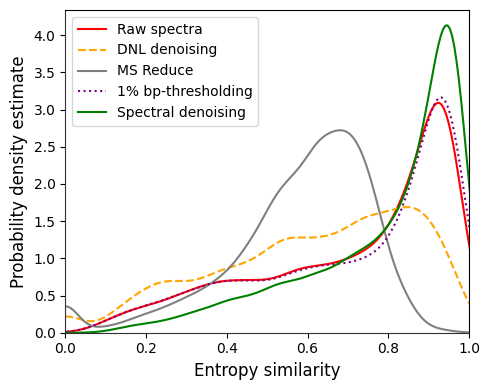

In [252]:
fig = plt.figure(figsize = (5, 4))#43
ax = fig.add_subplot()
sns.kdeplot(data_processed['entropy_similarity'], label= 'Raw spectra' , color = 'red', cumulative=False)
sns.kdeplot(data_processed['entropy_dyn'], label= 'DNL denoising' , color = 'orange', cumulative=False, linestyle = '--')

sns.kdeplot(data_processed['entropy_reduce'], label= 'MS Reduce' , color = 'grey', cumulative=False)
sns.kdeplot(data_processed['entropy_thres'], label= '1% bp-thresholding' , color = 'purple', cumulative=False, linestyle = ':')
sns.kdeplot(data_processed['denoised_similarity'], label= 'Spectral denoising' , color = 'green',cumulative=False)
plt.xlim(0, 1)
plt.grid(False)
ax.set_xlabel('Entropy similarity',size = 12)
ax.set_ylabel('Probability density estimate', size = 12)
ax.set_facecolor("white")
plt.legend(facecolor='white')
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')
# plt.legend()
fig.tight_layout()

# plt.savefig(os.path.join(figs_dir,'method_benchmarking_raw.png'))

# Reproducing results for artificial noise

In [33]:
raw_color =  'red'
dnl_color = 'orange'
mr_color = 'grey'
thr_color = 'purple'
sd_color = 'green'
import matplotlib.pyplot as plt

In [71]:
dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/dilution_series_data/synthetic_noise'
chemical_noise_level = 0.1
electronic_noise_level = 10
data_contaminated = read_df(os.path.join(dir, 'synthetic_noise_sn_'+str(chemical_noise_level)+'_'+str(electronic_noise_level)+'.csv'))

done read in df...


In [72]:
denoised_peaks_all = sd.spectral_denoising_batch(data_contaminated['msms_cont'], data_contaminated['smiles'], data_contaminated['adduct'])

100%|██████████| 6091/6091 [00:19<00:00, 319.17it/s]


In [73]:
data_contaminated['msms_cont_denoised']=denoised_peaks_all
data_contaminated['entropy_cont_denoised']=[entropy_similairty(data_contaminated['msms_cont_denoised'].iloc[i], data_contaminated['library_peaks'].iloc[i],data_contaminated['precursor_mz'].iloc[i]) for i in range(len(data_contaminated))]

entropy_dyn = []
entropy_thres = []
entropy_reduce = []
for index, row in tqdm(data_contaminated.iterrows(), total =len(data_contaminated)):
    msms_dyn =dnl_denoising(row['msms_cont'])
    entropy_dyn.append(entropy_similairty(row['library_peaks'], msms_dyn, pmz = row['precursor_mz']))
    msms_thres =threshold_denoising(row['msms_cont'], 1)
    entropy_thres.append(entropy_similairty(row['library_peaks'], msms_thres, pmz = row['precursor_mz']))
    msms_reduce = ms_reduce(row['msms_cont'])
    entropy_reduce.append(entropy_similairty(row['library_peaks'], msms_reduce, pmz = row['precursor_mz']))
data_contaminated['entropy_dyn']=entropy_dyn
data_contaminated['entropy_thres']=entropy_thres
data_contaminated['entropy_reduce']=entropy_reduce

100%|██████████| 6091/6091 [00:58<00:00, 104.98it/s]


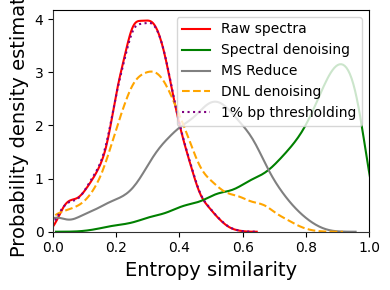

In [74]:
fig = plt.figure(figsize = (4, 3))#43
ax = fig.add_subplot()
sns.kdeplot(data_contaminated['entropy_cont_raw'], label= 'Raw spectra', color = raw_color)
sns.kdeplot(data_contaminated['entropy_cont_denoised'], label= 'Spectral denoising' ,color= sd_color)

sns.kdeplot(data_contaminated['entropy_reduce'], label= 'MS Reduce' ,color= mr_color)
sns.kdeplot(data_contaminated['entropy_dyn'], label= 'DNL denoising' ,color= dnl_color,linestyle = '--')
sns.kdeplot(data_contaminated['entropy_thres'], label= '1% bp thresholding' ,color= thr_color, linestyle = ':')
ax.set_xlabel('Entropy similarity',size = 14)
ax.set_ylabel('Probability density estimate', size = 14)
ax.set_facecolor("white")
ax.set_xlim(0,1)
plt.legend()
# ax.tick_params(labelsize=6)
fig.tight_layout()
ax.spines['left'].set_color('#313131')
ax.spines['bottom'].set_color('#313131')